In [5]:
import pandas as pd
from os.path import abspath, exists
from scipy import sparse
import numpy as np
from matplotlib import pyplot as plt
from sklearn.cluster import KMeans
import scipy
import collections
import time 
import sys

In [6]:
def removeIsolatedNodes(A):
    """
    this function takes A matrix as input and removes all isolated nodes
    """
    i = 1
    cn=0
    while(i<len(A)): 
        #node i is isolated
        if((sum(A[i,:]) == 0 and sum(A[:,i]) == 0)):
        #remove its related column
            A = np.delete(A, i, 0) 
            A = np.delete(A, i, 1)
            cn=1+cn
        else:
            i = i + 1
    return A

In [7]:
def isSymmetric(mat, N): 
    for i in range(N): 
        for j in range(N): 
            if (mat[i][j] != mat[j][i]): 
                return False
    return True

In [8]:
# read in node data
nodes = pd.read_csv('nodes.txt', quotechar="|", delimiter='\t', header=None)
nodes.columns = ['node', 'blog','political orientation','B']

# read in edge data
edges = pd.read_csv('edges.txt', quotechar="|", delimiter='\t', header=None)
edges.columns = ['from','to']

#create adjacency matrix
A = np.zeros((1490,1490))

for j in range(len(edges)):
    if (int(edges.loc[j]['from']) != int(edges.loc[j]['to'])):
        A[int(edges.loc[j]['from'])-1][int(edges.loc[j]['to'])-1] = 1
        A[int(edges.loc[j]['to'])-1][int(edges.loc[j]['from'])-1] = 1
    
A = removeIsolatedNodes(A)

# saving non zero nodes index after removing zeros
noneZeroNodes =[]
for i in range(len(A)):   
    if sum(A[i,:])>0:
       noneZeroNodes.append(i) 

# calculate degree matrix
D = np.zeros((len(A),len(A)))
for i in range(len(A)): 
    D[i][i] = sum(A[i,:])
    
    
# calculate laplasian matrix
L = D - A

#calculate eigenvalues and eigenvectors
v, s, _ = np.linalg.svd(L)
v = np.flip(v, 1)

In [6]:
maximumNo_k = 3
# maximumNo_k = 200
mismatch_vector = []
#iterating through different values of k
for k in range(maximumNo_k):
    k=(k+2)
    
    vt = v[:, 0:k]

    kmeans = KMeans(n_clusters=k,init="random").fit(vt)
    idx = kmeans.labels_
    
    trueLabel = []
    majority =[]
    mismatch =[]
    PointsIncluster  = []
    for c in range(k):
        index_tuple = np.where(idx==c) 
        #index of all points in cluster k=j+1
        cluster_index = index_tuple[0] 

        if (len(cluster_index)>0):
            trueLabel = []
            for c_indx in cluster_index:
                for nzn in noneZeroNodes: #this index starts from 0
                    if (c_indx==nzn):
                        trueLabel.append(nodes.loc[nzn+1]['political orientation'])
            occurrences = collections.Counter(trueLabel)
            PointsIncluster.append(len(cluster_index))
            if (occurrences[0] > occurrences[1]):
                majority.append(0)
                mismatch.append(float(occurrences[1]) / float(len(cluster_index)))
            else:
                mismatch.append (float(occurrences[0]) / float(len(cluster_index)))

    mismatch_sum = 0        
    for i,m in enumerate(mismatch):
        mismatch_sum = (m*PointsIncluster[i]) + mismatch_sum
    mismatch_rate = mismatch_sum/len(noneZeroNodes)
    mismatch_vector.append(mismatch_rate)

In [11]:
mismatch_vector

[0.3815359477124183, 0.3815359477124183, 0.3815359477124183]

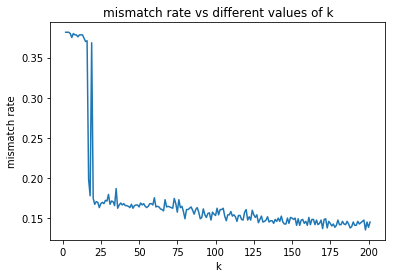

In [17]:
k=2
k_input=[]
while k<202:
    k_input.append(k)
    k = k+1
plt.plot(k_input,mismatch_vector )
plt.title('mismatch rate vs different values of k')
plt.xlabel("k")
plt.ylabel("mismatch rate")
plt.show()

In [9]:
isSymmetric(A, len(A))

True